---
# Student Info & Imports

Student info: Nadav Kahlon, ID: 213438575

In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import necessary packages
import torch
import torchvision
import datasets as ds
from torch import nn
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

# set manual seed for PyTorch (for reproducible results)
torch.manual_seed(0)

# Get available device, preferably GPU
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('Using device:', device)

Using device: cuda:0


---
# Question 2 - An RNN Cell With a "Reset" Gate
In this question we design and implement an RNN cell, acting as a simple Elman cell with an additional "reset" gate. We use instances of it to create a classification network, and overfit it on a small subset of the SST2 dataset to ensure that it can learn to process sequential data correctly.

## Overview of the Cell

The cell we will implement in this question maintains a single hidden-state passed through time, and updated according to a simple policy that allows the cell to "forget" parts of its state as it's passed to the next time unit.

Let's make a few notations first:
* Let $n_{in}$ be the the cell's input dimension.
* Let $n_{h}$ be the cell's hidden-state dimension.
* Let $x_t \in R^{n_{in}}$ be the cell's input at time $t$.
* Let $h_t \in R^{n_h}$ be the cell's hidden state at time $t$.

The cell calculates the value of its next hidden state in the following manner:

- First, it calculates a "candidate" hidden-state in the same way it's calculated in a simple Elman cell:

  $\hat{h_{t+1}}=\tanh(W_{hx}x_t+W_{hh}h_t+b_h)$
  
   Where:
  * $W_{hx} \in R^{n_h\times n_{in}}$ is a learned weight matrix which associates the cell's current input with its next hidden-state.
  * $W_{hh} \in R^{n_h\times n_h}$ is a learned weight matrix which associates the current hidden-state with the next hidden-state.
  * $b_h \in R^{n_h}$ is a learned bias vector.

* Then, it determines what in its hidden-state it should "forget" by calculating the *reset gate vecotr* $r_t\in R^{n_h}$ as follows:

  $r_{t+1} = \sigma(W_{rx}x_t + W_{rh}h_t + b_r)$

  Where:
  * $W_{rx}\in R^{n_h\times n_{in}}$ is a learned weight matrix which associates the reset operation with the cell's current input.
  * $W_{rh}\in R^{n_h\times n_h}$ is a learned weight matrix which associates the reset operation with the cell's current hidden-state.
  * $b_r\in R^{n_h}$ is a learned bias vector.
  * $\sigma$ is the sigmoid function, which maps the entire real-axis to the range between 0 and 1.

* Finally, it resets parts of the candidate hidden-state by multiplying it (component-wise) with the reset gate vector, and produces the cell's next hidden-state:

  $ h_{t+1} = \hat{h_{t+1}} \cdot r_{t+1}$

The following diagram sums-up the cell's behaviour:
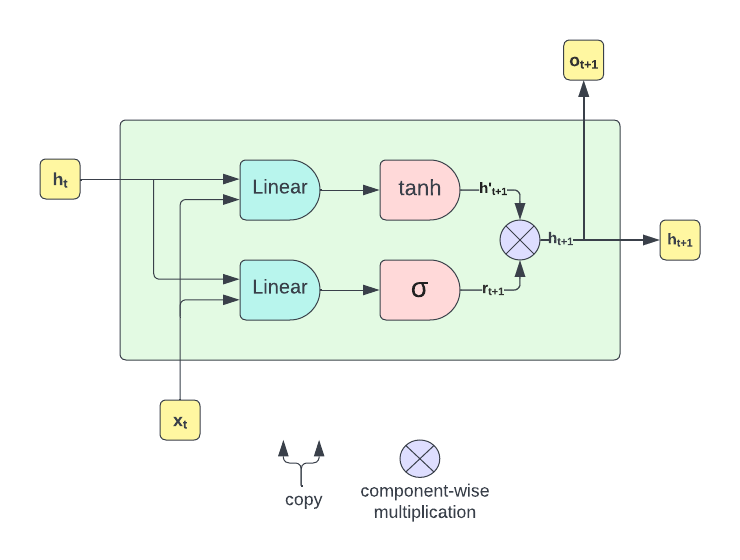

## The Motivation Behind the Design of the Reset-Gate

The idea of the reset gate is to allow the cell to *decide* what parts of its hidden state it should "forget", or more precisely - remove. Removing some of the latent information stored in the hidden-state vector can easily be done by setting some of its elements to 0 (discarding any information that was associated with them), or alternatively - multiplying them by a factor of 0. To make this process a bit more homogeneous, let's say that we will also multiply the other elements, just by a factor of 1 (so actually we won't change them at all - we'll "remember" the information they possess for next time). This whole process can be summed up by element-wise multiplication of the hidden state by a vector of zeros (the elemtent we discard) and ones (the elements we keep) - which we will call *the reset gate vector $r_t$*.

However, just picking a discrete vector of zeros and ones is not a differentiable process - and thus its parameters cannot be learned using gradiant-based optimization methods. Therefore, we look for a differentiable continuous alternative. The alternative I chose is inspired by the way we swithced from thinking in terms of binary classification - whose equivilant in this case is picking the 0 / 1 factor, to thinking in terms of logistic regression - which looks for a close continuous value between 0.0 and 1.0.

The idea is to let the cell produce a vector of values between 0.0 and 1.0 which will serve as the reset gate vector, and will be element-wise multiplied by the hidden-state. If it produces an element close to 0.0 - the efect is that the information associated with the corresponding hidden-state element will be discarded, and if it's close to 1.0 - it's keeped. It may also produce  values such as 0.5 - which will have the effect of keeping the information with "reduced influence".

As required, the reset-gate vector elements will only depend on the input to the cell at time $t$ - on the real vectors $x_t$ and $h_t$. The classic linear way to produce continuous values between 0.0 and 1.0 is logistic regression: a learned linear regressor producing a real number, followed by sigmoid activation that maps it to a value between 0.0 and 1.0. And just as the extremely powerfull deep MLP is based on simple linear models - we might as well use a simple linear model here.

All in all, what we'll add to the simple Elman cell is a unit that uses $n_h$ learned linear (actually affine) combinations of $x_t$ and $h_t$ followed by sigmoid activations, to produce a vector of $n_h$ real numbers between 0.0 and 1.0. This vector will then be element-wise multiplied by the candidate hidden-state the simple Elman part produced, and the result will be the new hidden state.

This is actually a well known method for discarding / keeping parts of a cell's state, that proved to be very successful as it's incorporated in the powerful LSTM and GRU units. Those units were my first source of inspiration.

## More Design Choices

In this cell I delve into more design choices I incorporated into the cell.

* To tackle the issue of producing the initial hidden state $h_0\in R^{n_h}$ (the hidden state of the cell before the first element of the sequence, $x_1$, is processed), I decided to make it a learned parameter. The inspiration for this choice was the way we, humans, process sequential data. We don't start from absolute scratch (from some "zero / random vector") - we start from a general initial knowledge we decided on after learning about our world. It only makes sense for the cell to decide what will work best for him, after learning about the nature of the training data. [This post](https://r2rt.com/non-zero-initial-states-for-recurrent-neural-networks.html) also supports this approach in its experimental results.

* About parameter initialization:

  * Weights: each weight is part of a linear unit, producing $n_h$ output neurons ($n_h$ elements of $\hat{h_t}$ or $r_t$) from $n_{in} + n_h$ input neurons (the $n_{in}$ elements of $x_t$ and the $n_h$ elements of $h_t$). Using [Xavier's initialization method](https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#xavier-initialization) (which I absolutely milked in my last 3 assignments :D), I decided to draw the weights from the uniform distriburion between $-l$ and $+l$, for $ l=\sqrt{\frac{6}{(n_{in}+n_h) + n_h}} $.

  * Biases: unfortunately, we haven't had a chance to study bias initialization in this course, so I did some research online. Most sources (such as Stanford's CS231n [lecture notes](https://cs231n.github.io/neural-networks-2/)) suggested to initialize biases of linear layers (through which information flows) to 0.0. Also, some resources specifically related to LSTM and GRUs (such as [these slides](https://www.cse.iitd.ac.in/~mausam/courses/col772/spring2018/lectures/12-tricks.pdf) of the Indian Institute of Technology and [this post](https://danijar.com/tips-for-training-recurrent-neural-networks/)) suggested to initialize the biases of the forget part of an LSTM to 1.0, to remeber more information by default; this intuition can be applied to our cell too. The former approach seemed reasonable for the candidate hidden-state bias $b_h$, and latter approach seemed reasonable for the reset gate bias $b_r$.

  * Initial hidden-state $h_0$: I couldn't really find anything about initializing the learned parameter $h_0$, so I just decided to use 0-initialization (as if the network has "zero initial knowledge" of the nature of the data before training).

## Implementation of the Cell

In [ ]:
'''
An RNN cell mimicking a simple Elman cell, with an additional reset gate.
'''
class ElmanResetCell(nn.Module):
    '''
    Constructor: creates a new ElmanReset RNN cell.
    Input:
      > 'n_in' - dimension of the input units to the cell.
      > 'n_hidden' - dimension of the hidden state of the cell.
    '''
    def __init__(self, n_in, n_hidden):
        # create the Module object
        super().__init__()

        # store dimensions
        self.n_in = n_in
        self.n_hidden = n_hidden

        # set weight matrices
        self.W_hx = nn.Parameter(torch.empty((n_hidden, n_in)))
        self.W_hh = nn.Parameter(torch.empty((n_hidden, n_hidden)))
        self.W_rx = nn.Parameter(torch.empty((n_hidden, n_in)))
        self.W_rh = nn.Parameter(torch.empty((n_hidden, n_hidden)))

        # initialize weights using Xavier's initialization (as described above)
        weight_bound = (6 / (n_in + 2*n_hidden)) ** 0.5
        nn.init.uniform_(self.W_hx, -weight_bound, +weight_bound)
        nn.init.uniform_(self.W_hh, -weight_bound, +weight_bound)
        nn.init.uniform_(self.W_rx, -weight_bound, +weight_bound)
        nn.init.uniform_(self.W_rh, -weight_bound, +weight_bound)

        # set bias vectors (as column vectors)
        self.b_h = nn.Parameter(torch.zeros((n_hidden,1)))
        self.b_r = nn.Parameter(torch.ones((n_hidden,1)))

        # set initial hidden state
        self.initial_h = nn.Parameter(torch.zeros(n_hidden))

        # set current hidden state
        self.h = None
        self.reset_h()
    
    '''
    Resets the hidden state of the cell to its initial value.
    '''
    def reset_h(self):
        # clone self.initialHiddenState (so outsiders won't accidentally change it)
        self.h = self.initial_h.clone()
        self.h.retain_grad()
    
    '''
    Forwards an input unit through the cell, updating its hidden state.
    Input:
      > 'x' - tensor of shape (n_in,) to forward through the cell
    '''
    def forward(self, x):
        # reshape x and h so they're column vectors
        x = x.reshape((-1, 1));
        h = self.h.reshape((-1,1))
        # calculate candidate hidden state and reset-gate vector
        h_hat = torch.tanh(self.W_hx @ x + self.W_hh @ h + self.b_h)
        r = torch.sigmoid(self.W_rx @ x + self.W_rh @ h + self.b_r)
        # use them to calculate the next hidden state
        self.h = (h_hat * r).reshape(-1)

    '''
    Returns a string containing information about the input and hidden dimensions
      of the cell. The output is of the format 'n_in={n_in}, n_out={n_out}'.
    '''
    def extra_repr(self):
        return f'n_in={self.n_in}, n_hidden={self.n_hidden}'
    

## Incorporating the Cell in a Deep Sentence Classifier for SST2



**Quick note:** since we train the model one sample at a time, parallel computation on GPU won't have much positive effect on the process (it may even harm it, since we will need to transfer the samples to GPU each time). Therefore, I decided to program the process to always run on the CPU (i.e., without ".to(device)" calls).

In [ ]:
''' In this cell we import and preprocess the SST2 dataset '''

# load dataset
dataset = ds.load_dataset('glue', 'sst2')
sentences = dataset['train']['sentence']
labels = dataset['train']['label']

# create a tokenizer and tokenize data
tokenizer = get_tokenizer('basic_english')
tokenized_sentences = list(map(tokenizer, sentences))

# build a vocabulary
vocab = build_vocab_from_iterator(tokenized_sentences,
                                  specials=["<UNK>"], min_freq=5)
vocab.set_default_index(0)

# map sentences to tensor of token indices, and labels to tensors
tokens_to_idxs = lambda tokens: torch.tensor(vocab(tokens))
sentences_token_idxs = list(map(tokens_to_idxs, tokenized_sentences))
labels = list(map(torch.tensor, labels))

# split to train / test partitions based on some split ratio
train_part = 0.2 # (20% train partition since we overfit on a small partition)
train_split = round(train_part * len(sentences))
train_tokens = sentences_token_idxs[:train_split]
train_labels = labels[:train_split]
test_tokens = sentences_token_idxs[train_split:]
test_labels = labels[train_split:]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
'''
A sentence classifier based on a deep recurrent network that makes use of ElmanReset
  cells.
'''
class ElmanResetClassifier(nn.Module):
    '''
    Constructor: creates a new deep recurrent sentence classifier (based on an 
      architecture of my design), incorporating ElmanReset cells.
    Input:
      > 'vocab_size' - the size of the vocabulary from which the input sentences
        are drawn.
      > 'embed_dim' - dimension of word embeddings for this vocabulary (which the
        model learns).
      > 'hidden_dim' - dimension of hidden state for the ElmanReset cells 
        incorporated in the model.
      > 'num_classes' - the number of output classes of the classifier.
    '''
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        # create the Module object
        super().__init__()
        
        # set a learned word embedding for this vocabulary
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # set 2 ElmanReset cells to which embedded sentences will be fed
        self.er_cell_1 = ElmanResetCell(embed_dim, hidden_dim)
        self.er_cell_2 = ElmanResetCell(hidden_dim, hidden_dim)

        # set a shallow classifying head
        self.linear = nn.Linear(hidden_dim, num_classes)
        self.logsoftmax = nn.LogSoftmax(dim=0)
    
    '''
    Forwards a sentence through the network.
    Input:
      > 'sentence' - list (or list-like) of indices of the tokenized words in the
        input sentence, in the same order they appear in the sentence.
    Returns a tensor of shape (num_classes,) containing the log of the output
      class probabilities produced by the classifier.
    '''
    def forward(self, sentence):
        # reset the cells' hidden state
        self.er_cell_1.reset_h()
        self.er_cell_2.reset_h()

        # sequentially process each token 
        for token in sentence:
            # embed the token
            embedded_token = self.embedding(token)
            # feed it through the recurrent cells
            self.er_cell_1(embedded_token)
            self.er_cell_2(self.er_cell_1.h)
        
        # feed the final hidden state through the classifying head
        feature_extractor_output = self.er_cell_2.h
        class_scores = self.linear(feature_extractor_output)
        logprobs = self.logsoftmax(class_scores)
        return logprobs

In [ ]:
# create a model for our data, and an optimizer for it
model = ElmanResetClassifier(vocab_size=len(vocab),
                             embed_dim=25,
                             hidden_dim=25,
                             num_classes=2)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
'''
Feeds a sentence through our created model, and performs an update step if
  necessary
Input:
  > 'tokens' - a list of the vocabulary indices of the tokens in the sentence.
  > 'label' - the actual label of the sentence.
  > 'to_step' - a boolean stating whether an update step should be performed on
    the model.
Returns a pair (loss, success) where:
  > 'loss' is the cross-entropy loss of the model on the sample.
  > 'success' is a boolean stating whether the model classified the sentence
    correctly.
'''
def feed_sentence(tokens, label, to_step):
    # prepare the model and optimizer for the operation
    if to_step:
      model.train()
      optimizer.zero_grad()
    else:
      model.eval()
    
    # feed the sentence
    logprobs = model(tokens)
    loss = -logprobs[label] # (softmax)
    with torch.no_grad():
        predicted_label = logprobs.argmax()
        success = (predicted_label == label)

    # backpropagate loss and step if necessary
    if to_step:
        loss.backward()
        optimizer.step()
    
    return loss.item(), success.item()

Epoch 1 / 10: 100%|██████████| 13470/13470 [04:02<00:00, 55.51it/s]


	Loss: 0.6574
	Accuracy: 60.88%


Epoch 2 / 10: 100%|██████████| 13470/13470 [04:02<00:00, 55.50it/s]


	Loss: 0.5143
	Accuracy: 74.88%


Epoch 3 / 10: 100%|██████████| 13470/13470 [04:00<00:00, 55.92it/s]


	Loss: 0.3834
	Accuracy: 83.11%


Epoch 4 / 10: 100%|██████████| 13470/13470 [04:02<00:00, 55.45it/s]


	Loss: 0.2965
	Accuracy: 87.86%


Epoch 5 / 10: 100%|██████████| 13470/13470 [04:02<00:00, 55.61it/s]


	Loss: 0.241
	Accuracy: 90.42%


Epoch 6 / 10: 100%|██████████| 13470/13470 [03:59<00:00, 56.30it/s]


	Loss: 0.1912
	Accuracy: 92.65%


Epoch 7 / 10: 100%|██████████| 13470/13470 [03:55<00:00, 57.19it/s]


	Loss: 0.1481
	Accuracy: 94.44%


Epoch 8 / 10: 100%|██████████| 13470/13470 [03:58<00:00, 56.36it/s]


	Loss: 0.1206
	Accuracy: 95.61%


Epoch 9 / 10: 100%|██████████| 13470/13470 [03:57<00:00, 56.71it/s]


	Loss: 0.1
	Accuracy: 96.41%


Epoch 10 / 10: 100%|██████████| 13470/13470 [04:01<00:00, 55.85it/s]


	Loss: 0.0939
	Accuracy: 96.64%


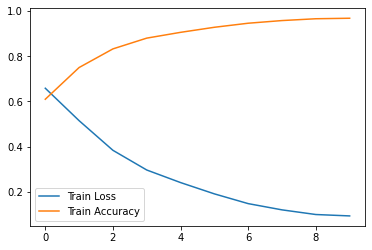

In [ ]:
''' In this cell we overfit the model on 20% of SST2's train partition '''

# lists to record the average loss and accuracy histories
loss_history = []
acc_history = []

# run 10 epochs of training
epochs = 10
for epoch in range(epochs):

    # variables to keep track of the total loss and of correct predictions
    total_loss = 0.0
    correct_preds = 0

    # perform update steps for every sample in the training partition
    for i, tokens in tqdm(enumerate(train_tokens),
                          f'Epoch {epoch+1} / {epochs}', total=len(train_tokens)):
        loss, success = feed_sentence(tokens, train_labels[i], to_step=True)
        total_loss += loss
        correct_preds += success

    # calculate, report, and record the average loss and accuracy during that epoch
    loss = (total_loss / len(train_tokens))
    accuracy = (correct_preds / len(train_tokens))
    print(f'\tLoss: {round(loss,4)}')
    print(f'\tAccuracy: {100 * round(accuracy, 4)}%')
    loss_history.append(loss)
    acc_history.append(accuracy)

# display training curves
plt.plot(loss_history, label='Train Loss')
plt.plot(acc_history, label='Train Accuracy')
plt.legend()
plt.show()

In [ ]:
''' In this cell we test the overfitted model on the test partition of our data. '''

# variables to keep track of the total loss and correct predictions
total_loss = 0.0
correct_preds = 0

# feed-forward every sample in the test set
for i, tokens in tqdm(enumerate(test_tokens),
                      f'Testing', total=len(test_tokens)):
    loss, success = feed_sentence(tokens, test_labels[i], to_step=False)
    total_loss += loss
    correct_preds += success

# calculate and report the average test loss and test accuracy
loss = (total_loss / len(test_tokens))
accuracy = (correct_preds / len(test_tokens))
print(f'\tTest loss: {round(loss,4)}')
print(f'\tTest accuracy: {100 * round(accuracy, 4)}%')

Testing: 100%|██████████| 53879/53879 [02:18<00:00, 387.96it/s]

	Test loss: 0.6338
	Test accuracy: 82.45%


---
# Question 3 - Inverser Autoencoder
In this question we design a deep autoencoder with the same number of encoder and decoder layers, and the special property that the $l$'th decoder layer's output is fit to be as close as possible to the $l$'th encoder layer's input - striving to inverse every encoder layer's input (and not only the first one). We create a fully connected and a fully convolutional versions of it, test them on the MNIST dataset, and compare the results.

## Generic Implementation

Before I present my implementation of the autoencoder, let me briefly explain the loss function I decided to incorporate into it.

The inverse-autoencoder should strive to inverse every encoder layer in the corresponding decoder layer, i.e. - it should be fit to make each decoder layer's output as close as possible to the corresponding encdoer layer's input. To enforce this, we need to impose a penalty for the distance between the input to each encoder layer, and the output of the corresponding decoder layer. Since those inputs and outputs contain real activation values, the natural way to define such distance is using sum of squared distances, or more precisely - MSE loss.

Now the question left is how to *combine* the errors of each encoder-decoder pair to obtain one global loss measure. The method I decided to use is to sum those errors, to produce the global loss. This is a very simple approach, but also very natural:
* First, it makes sense to make the global loss measure a linear combination of the individual errors. This makes the effect that each error has on the total loss independent of the other errors. I.e. - enforcing the "inversion" property of each decoder layer is carried-out independently.
* Next, we need to decide on the coefficients of this linear combination, i.e. - on the effect that each encoder-decoder layer error has on the total loss. I decided to go simple here - and make all effects equal. As a result, any differences between the "inversion-power" of each decoder layer will not be affected by our choices, but rather by the nature of the model and the data.

In [ ]:
 '''
An inverser autoencoder, as described above.
The module is implemeneted in a generic fashion, so different types of inverser
  autoencoders can be created uith it.
'''
class InverserAutoencoder(nn.Module):
    '''
    Constructor: creates a new inverser autoencoder, whose exact building blocks
      are specified by the caller.
    This constructor gets 2 callables - one for constructing encoder layers and
      one for constructing decoder layers. When ran on the same set of arguments,
      the constructors should produce together a matching pair of an encoder layer
      and a decoder layer - such that the input / output shapes of the encoder 
      layer are the same as the output / input shapes of the decoder layer,
      respectively.
    Then, to produce the autoencoder, we accept a list of argument sets to pass to
      both constructors. Each set produces a matching pair of encoding-decoding
      layers, which are then stacked in the correct order to produce a full-on
      autoencoder. The size of this list will determine the size of the network.
    Since the first and the last layers are usually unique, I added the option to
      manually specify these.
    Input:
      > 'encoder_layers_const' - the callable for constructing encoder layers, as
        described above in detail.
      > 'decoder_layers_const' - the callable for constructing decoder layers, as
        described above in detail.
      > 'layers_args_list' - a list of sets of arguments passed to both constructors 
        to produce matching pairs of encoder-decoder layers.
      > 'first_encoder_layer' - optional first encoder layer. Set to None if you 
        don't wish to use it. Default: None.
      > 'last_decoder_layer' - optional last decoder layer. Set to None if you don't
        wish to use it. Default: None.
    Note: if one of 'first_encode_layer' and 'last_decode_layer' is None, none of
      them will be added to the Module.
    '''
    def __init__(self, encoder_layers_const, decoder_layers_const, layers_args_list,
                 first_encoder_layer=None, last_decoder_layer=None):
        # create the Module object
        super().__init__()

        # set 2 ModuleList for the encoder layers and the decoder layers
        self.encoder_layers = nn.ModuleList()
        self.decoder_layers = nn.ModuleList() # (processed in reverse)

        # add first encoder layer and last decoder layer if necessary
        if first_encoder_layer != None and last_decoder_layer != None:
            self.encoder_layers.append(first_encoder_layer)
            self.decoder_layers.append(last_decoder_layer)
        
        # add the rest of the layers
        for layer_args in layers_args_list:
            self.encoder_layers.append(encoder_layers_const(layer_args))
            self.decoder_layers.append(decoder_layers_const(layer_args))

        # set 2 variable to hols lists to keep track of the encoder's inputs and 
        # the decoder's outputs during the last forward propagation
        self.encoder_inputs = None
        self.decoder_outputs = None

    '''
    Forwards an input tensor through the encoder part of the autoencoder.
    Input:  
      > 'x' - input tensor to forward (should be compatible with the encoder's 
        input shape)
    Returns the encoder's output.
    '''
    def encode(self, x):
        # reset the 'encoder_inputs' list (as we feed a new sample through it)
        self.encoder_inputs = []

        # feed x through the encoder layers
        for encoder_layer in self.encoder_layers:
            self.encoder_inputs.append(x)
            x = encoder_layer(x)
        return x

    '''
    Forwards an input tensor through the decoder part of the autoencoder.
    Input:  
      > 'x' - input tensor to forward (should be compatible with the decoder's 
        input shape)
    Returns the decoder's output.
    '''
    def decode(self, x):
        # reset the 'decoder_outputs' list (as we feed a new sample through it)
        self.decoder_outputs = []

        # feed x through the decoder layers (in reverse, as the last one is closest
        # to the last encoder layer)
        for decoder_layer in reversed(self.decoder_layers):
            x = decoder_layer(x)
            self.decoder_outputs.insert(0, x) # (insert to the beginning since reversed)
        return x

    '''
    Forwards an input tensor through the autoencoder.
    Input:  
      > 'x' - input tensor to forward (should be compatible with the first encoder
        input shape)
    Returns the auto-encoder output.
    '''
    def forward(self, x):
        # simply use 'encode' and 'decode' to feed the input through the network      
        encoder_output = self.encode(x)
        decoder_output = self.decode(encoder_output)
        return decoder_output
    
    '''
    Calculates the total loss of the autoencoder on the last input tensor that was
      fed through it.
    The loss of the inverser-autoencoder is defined as the sum of the loss between
      the input for each encoder layer, and the output of the correspodning decoder
      layer.
    Input:
        > 'loss_measure' - a 2 arguments callable that calculates the loss between
          an encoder layer's input and the correspodning decoder layer's output.
    Returns the total loss as described above (in tensor format, with autograd
      following it), or None if no input was fed through the model yet.
    '''
    def calc_loss(self, loss_measure):
        if self.encoder_inputs == None or self.decoder_outputs == None:
            # return None if no input was fet through the model yet
            return None
        else:
            # otherwise - sum the loss between every pair of encoder input and decoder
            # output
            return sum([loss_measure(encoder_input, decoder_output)
                        for encoder_input, decoder_output
                        in zip(self.encoder_inputs, self.decoder_outputs)])

## Preparing for Experiements

In [ ]:
''' In this cell we prepare the MNIST dataset for future experiments with the 
    inverser autoencoder '''

# load MNIST dataset
trans=torchvision.transforms.Compose(
    [torchvision.transforms.PILToTensor(),
     torchvision.transforms.ConvertImageDtype(torch.float)])
train_data = torchvision.datasets.MNIST(
    root="/MNIST", train=True, download=True, transform=trans)
test_data = torchvision.datasets.MNIST(
    root="/MNIST", train=False, download=True, transform=trans)
image_width, image_height = train_data[0][0].shape[1:]

# create dataloader for train data and test data
train_dataloader = DataLoader(train_data, batch_size=512,
                              num_workers=2,shuffle=True,pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=512,
                             num_workers=2,shuffle=False,pin_memory=True)

# since we try to recreate images, the loss measure we'll use will be MSE
loss_measure = nn.MSELoss()

# these 2 mapping lambdas will be used as a preprocess step and a postprocess step
# when feeding the images through the fully connected network (which is not
# compatibale for image data)
fc_preprocess = lambda x: x.view((x.shape[0], image_height * image_width)) # (flatten)
fc_postprocess = lambda x: x.view((x.shape[0], image_height, image_width)) # (unflatten)

In [ ]:
'''
Fits an instance of an InverserAutoencoder on the train partition of the MNIST
  dataset imported above.
Input:
  > 'model' - the InverserAutoencoder to fit (set on 'device').
  > 'optimizer' - the attached optimizer used for fitting.
  > 'epochs' - the number of training epochs to run.
  > 'preprocess' - a callable called on the loaded input batches before feeding
    them through the model. Set to None if you don't wish to use this functionality.
    Default: None
Output:  a list of the history of the losses of the model on the training batches.
Documents the process in real time using the tqdm package.
'''
def train_model(model, optimizer, epochs, preprocess=None):
    # set a list to track the loss history
    loss_history = []

    # run 'epochs' training epochs
    for epoch in range(epochs):
        total_loss = 0.0

        # process each training batch individually
        for (imgs, _) in tqdm(train_dataloader,
                              f'Training epoch {epoch+1} / {epochs}',
                              position=0, leave=True):

            # prepare batch
            imgs = imgs.to(device)
            if preprocess != None: imgs = preprocess(imgs)
            
            # run forward and backward passes on the batch
            optimizer.zero_grad()
            model.train()
            model(imgs)
            loss = model.calc_loss(loss_measure)
            loss.backward()
            optimizer.step()

            # record batch loss
            loss_history.append(loss.item())
            total_loss += loss.item()
        
        # report the epoch's average loss
        print(f'\tLoss: {round(total_loss/len(train_dataloader),4)}')
    
    return loss_history

In [ ]:
'''
Tests an instance of an InverserAutoencoder on the test partition of the MNIST
  dataset imported above.
Input:
  > 'model' - the InverserAutoencoder to test (set on 'device').
  > 'preprocess' - a callable called on the loaded input batches before feeding
    them through the model. Set to None if you don't wish to use this functionality.
    Default: None
Returns the average loss on the test set.
'''
def test_model(model, preprocess=None):
    with torch.no_grad():
        # variable to keep track of the total MSE loss over the batches
        total_loss = 0.0

        # process each testing batch individually
        for (imgs, _) in tqdm(test_dataloader, f'Testing', position=0, leave=True):

            # prepare batch
            imgs = imgs.to(device)
            if preprocess != None: imgs = preprocess(imgs)

            # feed the batch through the model and add the loss
            model.eval()
            model(imgs)
            loss = model.calc_loss(loss_measure)
            total_loss += loss.item()
    
    # return average batch loss
    return total_loss / len(test_dataloader)

In [ ]:
'''
Visualizes the output of an instance of an InverserAutoencoder on a few samples
  from the beginning of the test partition of the MNIST dataset.
Input:
  > 'model' - the InverserAutoencoder to visualize its outputs (set on 'device').
  > 'num_samples' - the number of samples from the beginning of the test partition
    of MNIST to use for visualization.
  > 'preprocess' - a callable called on the loaded input samples before feeding
    them through the model. Set to None if you don't wish to use this functionality.
    Default: None
  > 'postprocess' - a callable called on the output of the model (before removing
    batch dimension) to make its shape correct for image visualization. Set to
    None if you don't wish to use this functionality. Default: None
'''
def visualize_model_results(model, num_samples, preprocess=None, postprocess=None):
    # process the first 'num_samples' samples of the test partition
    for i in range(num_samples):
        origin_img = test_data[i][0].to(device)
        img = origin_img
        if preprocess != None: img = preprocess(img)
        recon_img = model(img)
        if postprocess != None: recon_img = postprocess(recon_img)
        recon_img = recon_img.detach()

        # create new figure and subplots
        fig = plt.figure()
        axis1, axis2 = fig.subplots(1,2)

        # visualize original image
        axis1.imshow(origin_img.squeeze().cpu().numpy(), cmap='gray')
        axis1.axis('off')
        axis1.set_title('Original')

        # visualize reconstructed image
        axis2.imshow(recon_img.squeeze().cpu().numpy(), cmap='gray')
        axis2.axis('off')
        axis2.set_title('Reconstructed')

In [ ]:
'''
Tests an instance of an InverserAuto encoder to see how close each decoder layer of
  it is to the inverse of the corresponding encdoer layer.
Input:
  > 'model' - the InverserAutoencoder to test (set on 'device').
  > 'preprocess' - a callable called on the loaded input batches before feeding
    them through the model. Set to None if you don't wish to use this functionality.
    Default: None
Returns a list whose i'th element is the average MSE loss between the input to the
  i'th encoder layer and the output of the i'th decoder layer (from its end), 
  measured on the test partition of MNIST.
'''
def test_model_inversion(model, preprocess=None):
    with torch.no_grad():
        # initialize a list to store the total loss between each layer pair
        total_losses = [0.0] * len(model.encoder_layers)

        # process each testing batch individually
        for (imgs, _) in tqdm(test_dataloader, f'Testing inversion',
                              position=0, leave=True):

            # prepare and feed batch
            imgs = imgs.to(device)
            if preprocess != None: imgs = preprocess(imgs)
            model.eval()
            model(imgs)

            # calculate and record loss between pairs of layers of the autoencoder
            for i, (encoder_input, decoder_output) \
                  in enumerate(zip(model.encoder_inputs, model.decoder_outputs)):
                total_losses[i] += loss_measure(encoder_input,decoder_output).item()

        # divide each total loss by the number of batches to obtain average losses
    avg_losses = [total_loss / len(test_dataloader)
                  for total_loss in total_losses]

    return avg_losses

In [ ]:
'''
Tests how an instance of an InverserAutoencoder behaves when applying noise to its
  decoder's input.
Input:
  > 'model' - the InverserAutoencoder to test (set on 'device').
  > 'preprocess' - a callable called on the loaded input batches before feeding
    them through the model. Set to None if you don't wish to use this functionality.
    Default: None
  > 'postprocess' - a callable called on the output of the model (before removing
    batch dimension) to make its shape correct for image visualization. Set to
    None if you don't wish to use this functionality. Default: None
Displays 2 matplotlib figures:
  > The first figure contains 3 subplots:
    - One containing the first sample in the test partition of MKNIST.
    - One containing the autoencoder's output on this sample.
    - And one containing the decoder's output on the sample's encoding (produced)
      by the encoder), after adding random gaussian noise with mean 0 and std 1.25%.
  > The second figure contains the decoded image produced by the inverser's decoder,
    when feeding random (standard) gaussian noise to it.
'''
def test_noise_behavior(model, preprocess=None, postprocess=None):
    # start with the first experiement - adding noise to a real sample's encoding:

    # prepare data and feed it through
    img = test_data[0][0].to(device)
    if preprocess != None: img = preprocess(img)
    encoding = model.encode(img)
    decoded_img = model.decode(encoding)
    noisy_encoding = encoding + 0.0125 * torch.randn_like(encoding)
    noisy_decoded_img = model.decode(noisy_encoding)

    # postprocess if necessary
    if postprocess != None:
        img = postprocess(img)
        decoded_img = postprocess(decoded_img)
        noisy_decoded_img = postprocess(noisy_decoded_img)

    # display the results
    fig = plt.figure(figsize=(10,10))
    axes = fig.subplots(1,3)
    axes[0].imshow(img.cpu().detach().numpy().squeeze(), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Original Image')
    axes[1].imshow(decoded_img.cpu().detach().numpy().squeeze(), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Decoded Image Encoding')
    axes[2].imshow(noisy_decoded_img.cpu().detach().numpy().squeeze(), cmap='gray')
    axes[2].axis('off')
    axes[2].set_title('Decoded Noisy Image Encoding')

    # next - the second experiement: decode random noise
    
    # create and decode noise
    noise = torch.randn_like(encoding).to(device)
    decoded_noise = model.decode(noise)
    if postprocess != None: decoded_noise = postprocess(decoded_noise)

    # display the result
    fig = plt.figure()
    axis = fig.subplots(1,1)
    axis.imshow(decoded_noise.cpu().detach().numpy().squeeze(), cmap='gray')
    axis.axis('off')
    axis.set_title('Decoded Noise')

## Fitting & Testing a Fully-Connected Inverser Autoencoder on MNIST

In [ ]:
''' In this cell we create a fully-connected version of InverserAutoencoder '''

# a constructor for internal encoder layers of the model: FC + LeakyReLU
encoder_layers_const = lambda args_dict: nn.Sequential(
    nn.Linear(args_dict['in_features'], args_dict['out_features']),
    nn.LeakyReLU())

# a constructor for inverse decoder layers of the model: FC + LeakyReLU
decoder_layers_const = lambda args_dict: nn.Sequential(
    nn.Linear(args_dict['out_features'], args_dict['in_features']),
    nn.LeakyReLU())

# the first encoder layer will be just as the others
first_encoder_layer = encoder_layers_const(
    {'in_features': image_height*image_width, 'out_features': 512})

# the matching last decoder layer is a bit special - it uses sigmoid activation to 
# producepixel values bwwteen 0.0 and 1.0
last_decoder_layer = nn.Sequential(
    nn.Linear(512, image_height*image_width,
    nn.Sigmoid()))

# these are argument lists we will use to produce the internal layers
layers_args_list = [{'in_features': 512, 'out_features': 256},
                    {'in_features': 256, 'out_features': 128},
                    {'in_features': 128, 'out_features': 64},
                    {'in_features': 64, 'out_features': 32}]

# create the model
fc_inverser = InverserAutoencoder(encoder_layers_const, decoder_layers_const,
                                  layers_args_list, first_encoder_layer,
                                  last_decoder_layer).to(device)

In [ ]:
# attach optimizer to the model and fit it
optimizer = torch.optim.Adam(fc_inverser.parameters(), lr=3e-3)
fc_loss_history = train_model(fc_inverser, optimizer, epochs=50,
                           preprocess=fc_preprocess)

Training epoch 1 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.70it/s]


	Loss: 0.0698


Training epoch 2 / 50: 100%|██████████| 118/118 [00:10<00:00, 10.73it/s]


	Loss: 0.0612


Training epoch 3 / 50: 100%|██████████| 118/118 [00:15<00:00,  7.72it/s]


	Loss: 0.0578


Training epoch 4 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.04it/s]


	Loss: 0.0538


Training epoch 5 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.73it/s]


	Loss: 0.0505


Training epoch 6 / 50: 100%|██████████| 118/118 [00:14<00:00,  8.19it/s]


	Loss: 0.0471


Training epoch 7 / 50: 100%|██████████| 118/118 [00:14<00:00,  8.04it/s]


	Loss: 0.0435


Training epoch 8 / 50: 100%|██████████| 118/118 [00:11<00:00,  9.93it/s]


	Loss: 0.0413


Training epoch 9 / 50: 100%|██████████| 118/118 [00:13<00:00,  8.69it/s]


	Loss: 0.0399


Training epoch 10 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.35it/s]


	Loss: 0.0382


Training epoch 11 / 50: 100%|██████████| 118/118 [00:13<00:00,  8.97it/s]


	Loss: 0.0362


Training epoch 12 / 50: 100%|██████████| 118/118 [00:11<00:00,  9.93it/s]


	Loss: 0.0344


Training epoch 13 / 50: 100%|██████████| 118/118 [00:14<00:00,  8.19it/s]


	Loss: 0.0332


Training epoch 14 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.73it/s]


	Loss: 0.0323


Training epoch 15 / 50: 100%|██████████| 118/118 [00:13<00:00,  8.95it/s]


	Loss: 0.0315


Training epoch 16 / 50: 100%|██████████| 118/118 [00:16<00:00,  7.31it/s]


	Loss: 0.0305


Training epoch 17 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.14it/s]


	Loss: 0.0301


Training epoch 18 / 50: 100%|██████████| 118/118 [00:13<00:00,  8.52it/s]


	Loss: 0.0292


Training epoch 19 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.55it/s]


	Loss: 0.0285


Training epoch 20 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.78it/s]


	Loss: 0.028


Training epoch 21 / 50: 100%|██████████| 118/118 [00:13<00:00,  8.79it/s]


	Loss: 0.0275


Training epoch 22 / 50: 100%|██████████| 118/118 [00:14<00:00,  7.95it/s]


	Loss: 0.0268


Training epoch 23 / 50: 100%|██████████| 118/118 [00:14<00:00,  8.18it/s]


	Loss: 0.0263


Training epoch 24 / 50: 100%|██████████| 118/118 [00:14<00:00,  8.03it/s]


	Loss: 0.0259


Training epoch 25 / 50: 100%|██████████| 118/118 [00:15<00:00,  7.79it/s]


	Loss: 0.0255


Training epoch 26 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.67it/s]


	Loss: 0.0253


Training epoch 27 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.29it/s]


	Loss: 0.0249


Training epoch 28 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.47it/s]


	Loss: 0.0246


Training epoch 29 / 50: 100%|██████████| 118/118 [00:14<00:00,  8.17it/s]


	Loss: 0.0244


Training epoch 30 / 50: 100%|██████████| 118/118 [00:13<00:00,  8.81it/s]


	Loss: 0.024


Training epoch 31 / 50: 100%|██████████| 118/118 [00:13<00:00,  8.97it/s]


	Loss: 0.0239


Training epoch 32 / 50: 100%|██████████| 118/118 [00:15<00:00,  7.46it/s]


	Loss: 0.0236


Training epoch 33 / 50: 100%|██████████| 118/118 [00:13<00:00,  8.54it/s]


	Loss: 0.0234


Training epoch 34 / 50: 100%|██████████| 118/118 [00:13<00:00,  8.72it/s]


	Loss: 0.0232


Training epoch 35 / 50: 100%|██████████| 118/118 [00:15<00:00,  7.62it/s]


	Loss: 0.0228


Training epoch 36 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.67it/s]


	Loss: 0.0227


Training epoch 37 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.28it/s]


	Loss: 0.0224


Training epoch 38 / 50: 100%|██████████| 118/118 [00:13<00:00,  8.78it/s]


	Loss: 0.0223


Training epoch 39 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.11it/s]


	Loss: 0.0221


Training epoch 40 / 50: 100%|██████████| 118/118 [00:15<00:00,  7.65it/s]


	Loss: 0.0218


Training epoch 41 / 50: 100%|██████████| 118/118 [00:13<00:00,  8.77it/s]


	Loss: 0.0218


Training epoch 42 / 50: 100%|██████████| 118/118 [00:10<00:00, 10.73it/s]


	Loss: 0.0217


Training epoch 43 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.68it/s]


	Loss: 0.0213


Training epoch 44 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.62it/s]


	Loss: 0.0212


Training epoch 45 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.47it/s]


	Loss: 0.0209


Training epoch 46 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.72it/s]


	Loss: 0.0209


Training epoch 47 / 50: 100%|██████████| 118/118 [00:10<00:00, 10.82it/s]


	Loss: 0.0207


Training epoch 48 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.70it/s]


	Loss: 0.0206


Training epoch 49 / 50: 100%|██████████| 118/118 [00:10<00:00, 10.82it/s]


	Loss: 0.0206


Training epoch 50 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.68it/s]

	Loss: 0.0201


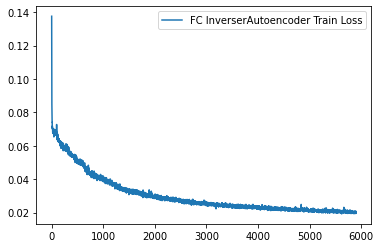

Testing: 100%|██████████| 20/20 [00:03<00:00,  6.45it/s]


	FC InverserAutoencoder Test loss: 0.0207



Testing inversion: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


	Inversion loss between encoder-decoder pair 0 of FC InverserAutoencoder: 0.0197
	Inversion loss between encoder-decoder pair 1 of FC InverserAutoencoder: 0.0006
	Inversion loss between encoder-decoder pair 2 of FC InverserAutoencoder: 0.0002
	Inversion loss between encoder-decoder pair 3 of FC InverserAutoencoder: 0.0001
	Inversion loss between encoder-decoder pair 4 of FC InverserAutoencoder: 0.0001

The loss between the furthest pair of encoder-decoder layers in FC InverserAutoencoderis is 95.16% of the total test loss.



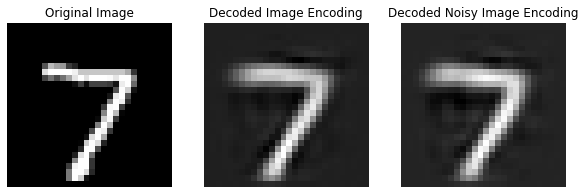

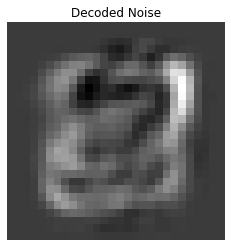

In [ ]:
''' In this cell we test the fully-connected inverser autoencoder '''

# plot loss history
plt.plot(fc_loss_history, label='FC InverserAutoencoder Train Loss')
plt.legend()
plt.show()
print()

# calculate test loss
test_loss = test_model(fc_inverser, fc_preprocess)
print(f'\tFC InverserAutoencoder Test loss: {round(test_loss,4)}')

# calculate loss per pair of encoder-decoder layers
print()
pair_losses = test_model_inversion(fc_inverser, fc_preprocess)
for i, pair_loss in enumerate(pair_losses):
    print(f'\tInversion loss between encoder-decoder pair {i} of FC InverserAutoencoder:',
          f'{round(pair_losses[i],4)}')

# calculate the part of the first (furthest) encoder-decoder pair in the total loss
furthest_pair_loss_part = pair_losses[0] / sum(pair_losses)
print(f'\nThe loss between the furthest pair of encoder-decoder layers in FC',
      f'InverserAutoencoderis is {round(furthest_pair_loss_part,4)*100}% of the',
      'total test loss.')

# test the model's behavior with noisy encodings
print()
test_noise_behavior(fc_inverser, fc_preprocess, fc_postprocess)

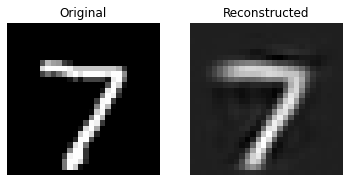

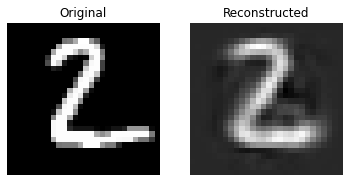

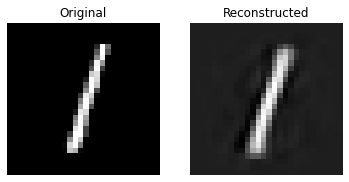

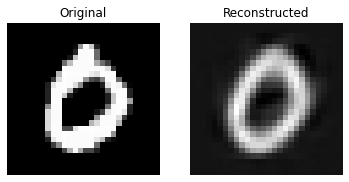

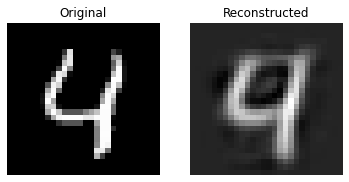

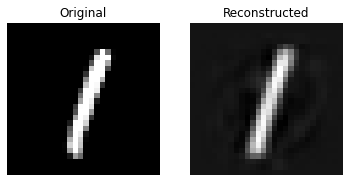

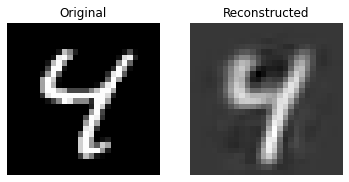

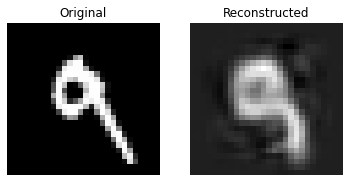

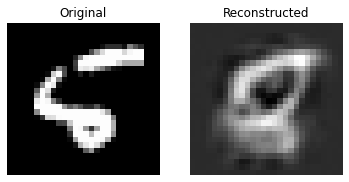

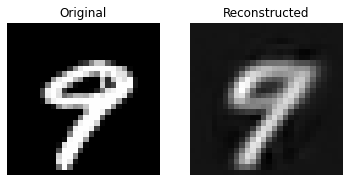

In [ ]:
# visualize the output of the model for a few test samples
num_samples = 10
visualize_model_results(fc_inverser, num_samples, fc_preprocess, fc_postprocess)

## Fitting & Testing a Fully-Convolutional Inverser Autoencoder on MNIST

In [ ]:
''' In this cell we create a fully-convolutional version of InverserAutoencoder '''

# a constructor for internal encoder layers of the model: Conv2d + LeakyReLU
encoder_layers_const = lambda args_dict: nn.Sequential(
    torch.nn.Conv2d(args_dict['in_channels'], args_dict['out_channels'],
                    args_dict['kernel_size'], args_dict['stride'],
                    args_dict['padding']),
    nn.LeakyReLU())

# a constructor for inverse decoder layers of the model: ConvTranspose2d + LeakyReLU
decoder_layers_const = lambda args_dict: nn.Sequential(
    torch.nn.ConvTranspose2d(args_dict['out_channels'], args_dict['in_channels'],
                             args_dict['kernel_size'], args_dict['stride'],
                             args_dict['padding']),
    nn.LeakyReLU())

# the first encoder layer will be just as the others, preparing for 1 channel input
first_encoder_layer = encoder_layers_const(
    {'in_channels': 1, 'out_channels': 2,
     'kernel_size': 4, 'stride': 2, 'padding': 3}) # output shape (2,16,16)

# the matching last decoder layer is a bit special - it uses sigmoid activation to 
# produce pixel values bwwteen 0.0 and 1.0
last_decoder_layer = nn.Sequential(
    torch.nn.ConvTranspose2d(in_channels=2, out_channels=1,
                             kernel_size=4, stride=2, padding=3),
    nn.Sigmoid())

# these are argument lists we will use to produce the internal layers
layers_args_list = [{'in_channels': 2, 'out_channels': 4, # output shape (4,8,8)
                      'kernel_size': 4, 'stride': 2, 'padding': 1},
                    {'in_channels': 4, 'out_channels': 8, # output shape (8,4,4)
                      'kernel_size': 4, 'stride': 2, 'padding': 1},
                    {'in_channels': 8, 'out_channels': 16, # output shape (16,2,2)
                      'kernel_size': 4, 'stride': 2, 'padding': 1},
                    {'in_channels': 16, 'out_channels': 32, # output shape (32,1,1)
                      'kernel_size': 4, 'stride': 2, 'padding': 1}]
# create the model
conv_inverser = InverserAutoencoder(encoder_layers_const, decoder_layers_const,
                                  layers_args_list, first_encoder_layer,
                                  last_decoder_layer).to(device)

# to ensure shapes are appropriate, let's test the model on some train samples
print('Testing input & output shapes of the fully-convolutional inverser autoencoder:')
sample = train_data[0][0].to(device)
conv_inverser(sample)
for i, (encoder_input, decoder_output) in enumerate(zip(conv_inverser.encoder_inputs,
                                                        conv_inverser.decoder_outputs)):
    print(f'\tEncder input {i} shape: {tuple(encoder_input.shape)} |',
          f'Decoder output {i} shape: {tuple(decoder_output.shape)}')

Testing input & output shapes of the fully-convolutional inverser autoencoder:
	Encder input 0 shape: (1, 28, 28) | Decoder output 0 shape: (1, 28, 28)
	Encder input 1 shape: (2, 16, 16) | Decoder output 1 shape: (2, 16, 16)
	Encder input 2 shape: (4, 8, 8) | Decoder output 2 shape: (4, 8, 8)
	Encder input 3 shape: (8, 4, 4) | Decoder output 3 shape: (8, 4, 4)
	Encder input 4 shape: (16, 2, 2) | Decoder output 4 shape: (16, 2, 2)


In [ ]:
# attach optimizer to the model and fit it
optimizer = torch.optim.Adam(conv_inverser.parameters(), lr=3e-3)
conv_loss_history = train_model(conv_inverser, optimizer, epochs=50)

Training epoch 1 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.79it/s]


	Loss: 0.1846


Training epoch 2 / 50: 100%|██████████| 118/118 [00:10<00:00, 10.77it/s]


	Loss: 0.1193


Training epoch 3 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.69it/s]


	Loss: 0.0832


Training epoch 4 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.68it/s]


	Loss: 0.0723


Training epoch 5 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.66it/s]


	Loss: 0.0637


Training epoch 6 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.70it/s]


	Loss: 0.0588


Training epoch 7 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.56it/s]


	Loss: 0.0547


Training epoch 8 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.64it/s]


	Loss: 0.0508


Training epoch 9 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.54it/s]


	Loss: 0.0472


Training epoch 10 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.64it/s]


	Loss: 0.0439


Training epoch 11 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.63it/s]


	Loss: 0.0409


Training epoch 12 / 50: 100%|██████████| 118/118 [00:14<00:00,  8.07it/s]


	Loss: 0.0383


Training epoch 13 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.58it/s]


	Loss: 0.0359


Training epoch 14 / 50: 100%|██████████| 118/118 [00:16<00:00,  7.14it/s]


	Loss: 0.034


Training epoch 15 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.12it/s]


	Loss: 0.0323


Training epoch 16 / 50: 100%|██████████| 118/118 [00:15<00:00,  7.76it/s]


	Loss: 0.0306


Training epoch 17 / 50: 100%|██████████| 118/118 [00:10<00:00, 10.76it/s]


	Loss: 0.0291


Training epoch 18 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.65it/s]


	Loss: 0.0279


Training epoch 19 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.61it/s]


	Loss: 0.0269


Training epoch 20 / 50: 100%|██████████| 118/118 [00:13<00:00,  8.60it/s]


	Loss: 0.0257


Training epoch 21 / 50: 100%|██████████| 118/118 [00:15<00:00,  7.60it/s]


	Loss: 0.0249


Training epoch 22 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.08it/s]


	Loss: 0.024


Training epoch 23 / 50: 100%|██████████| 118/118 [00:14<00:00,  8.03it/s]


	Loss: 0.0234


Training epoch 24 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.01it/s]


	Loss: 0.0227


Training epoch 25 / 50: 100%|██████████| 118/118 [00:11<00:00,  9.98it/s]


	Loss: 0.022


Training epoch 26 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.24it/s]


	Loss: 0.0214


Training epoch 27 / 50: 100%|██████████| 118/118 [00:14<00:00,  8.30it/s]


	Loss: 0.021


Training epoch 28 / 50: 100%|██████████| 118/118 [00:13<00:00,  8.66it/s]


	Loss: 0.0207


Training epoch 29 / 50: 100%|██████████| 118/118 [00:14<00:00,  8.24it/s]


	Loss: 0.0202


Training epoch 30 / 50: 100%|██████████| 118/118 [00:15<00:00,  7.75it/s]


	Loss: 0.0196


Training epoch 31 / 50: 100%|██████████| 118/118 [00:15<00:00,  7.41it/s]


	Loss: 0.0195


Training epoch 32 / 50: 100%|██████████| 118/118 [00:13<00:00,  8.69it/s]


	Loss: 0.019


Training epoch 33 / 50: 100%|██████████| 118/118 [00:13<00:00,  8.85it/s]


	Loss: 0.0187


Training epoch 34 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.71it/s]


	Loss: 0.0186


Training epoch 35 / 50: 100%|██████████| 118/118 [00:15<00:00,  7.44it/s]


	Loss: 0.0181


Training epoch 36 / 50: 100%|██████████| 118/118 [00:14<00:00,  8.17it/s]


	Loss: 0.018


Training epoch 37 / 50: 100%|██████████| 118/118 [00:15<00:00,  7.60it/s]


	Loss: 0.0178


Training epoch 38 / 50: 100%|██████████| 118/118 [00:17<00:00,  6.87it/s]


	Loss: 0.0174


Training epoch 39 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.48it/s]


	Loss: 0.0174


Training epoch 40 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.61it/s]


	Loss: 0.0173


Training epoch 41 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.64it/s]


	Loss: 0.0169


Training epoch 42 / 50: 100%|██████████| 118/118 [00:11<00:00, 10.67it/s]


	Loss: 0.0168


Training epoch 43 / 50: 100%|██████████| 118/118 [00:15<00:00,  7.57it/s]


	Loss: 0.0166


Training epoch 44 / 50: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


	Loss: 0.0164


Training epoch 45 / 50: 100%|██████████| 118/118 [00:18<00:00,  6.52it/s]


	Loss: 0.0163


Training epoch 46 / 50: 100%|██████████| 118/118 [00:16<00:00,  7.24it/s]


	Loss: 0.0161


Training epoch 47 / 50: 100%|██████████| 118/118 [00:12<00:00,  9.44it/s]


	Loss: 0.016


Training epoch 48 / 50: 100%|██████████| 118/118 [00:17<00:00,  6.88it/s]


	Loss: 0.0157


Training epoch 49 / 50: 100%|██████████| 118/118 [00:15<00:00,  7.44it/s]


	Loss: 0.0157


Training epoch 50 / 50: 100%|██████████| 118/118 [00:11<00:00,  9.89it/s]

	Loss: 0.0156


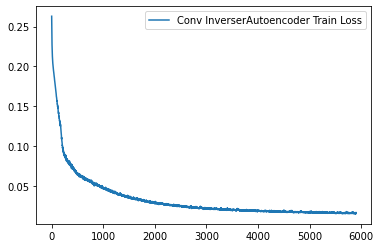

Testing: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


	Conv InverserAutoencoder Test loss: 0.0152



Testing inversion: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]



	Inversion loss between encoder-decoder pair 0 of Conv InverserAutoencoder: 0.0136
	Inversion loss between encoder-decoder pair 1 of Conv InverserAutoencoder: 0.0012
	Inversion loss between encoder-decoder pair 2 of Conv InverserAutoencoder: 0.0002
	Inversion loss between encoder-decoder pair 3 of Conv InverserAutoencoder: 0.0001
	Inversion loss between encoder-decoder pair 4 of Conv InverserAutoencoder: 0.0001

The loss between the furthest pair of encoder-decoder layers in Conv InverserAutoencoderis is 89.27000000000001% of the total test loss.



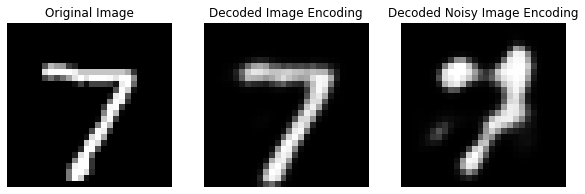

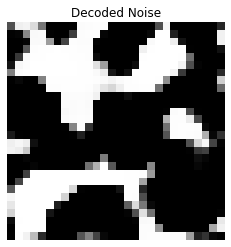

In [ ]:
''' In this cell we test the fully-convolutionl inverser autoencoder '''

# plot loss history
plt.plot(conv_loss_history, label='Conv InverserAutoencoder Train Loss')
plt.legend()
plt.show()

# calculate test loss
test_loss = test_model(conv_inverser)
print(f'\tConv InverserAutoencoder Test loss: {round(test_loss,4)}')

# calculate loss per pair of encoder-decoder layers
print()
pair_losses = test_model_inversion(conv_inverser)
print()
for i, pair_loss in enumerate(pair_losses):
    print(f'\tInversion loss between encoder-decoder pair {i} of Conv InverserAutoencoder:',
          f'{round(pair_losses[i],4)}')

# calculate the part of the first (furthest) encoder-decoder pair in the total loss
furthest_pair_loss_part = pair_losses[0] / sum(pair_losses)
print(f'\nThe loss between the furthest pair of encoder-decoder layers in Conv',
      f'InverserAutoencoderis is {round(furthest_pair_loss_part,4)*100}% of the',
      'total test loss.')

# test the model's behavior with noisy encodings
print()
test_noise_behavior(conv_inverser)

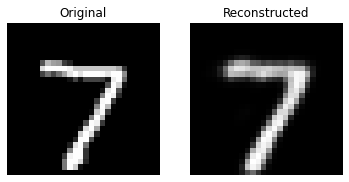

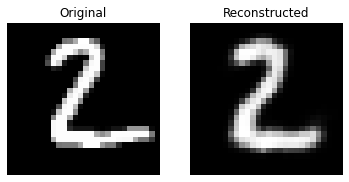

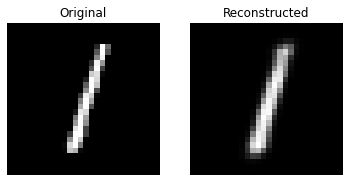

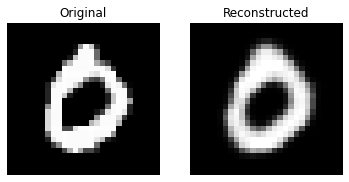

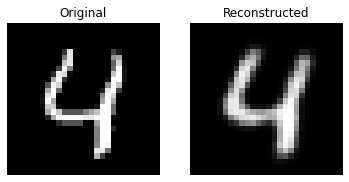

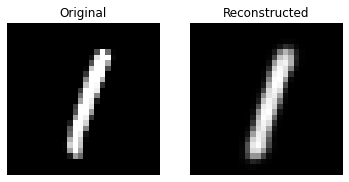

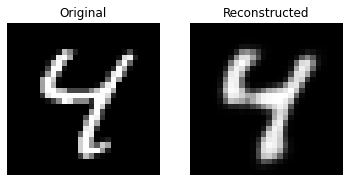

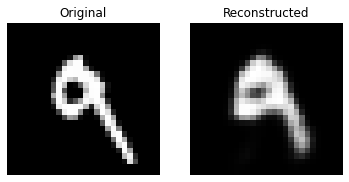

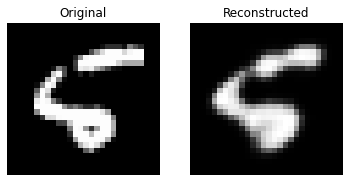

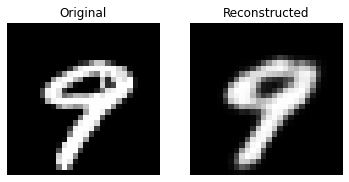

In [ ]:
# visualize the output of the model for a few test samples
num_samples = 10
visualize_model_results(conv_inverser, num_samples)

## Analyzing the Results

### Key Differences Between the Models

Let's first try to understand the difference both models have in nature.

1. The first key difference is that the convolutional model, which uses local operations such as convolution and deconvolution, processes the samples and produces the decoded images *locally* - each layer operates in the same way around every area of the feature map. In contrast the FC version, which uses fully-connected layers, relate to each neuron (feature or pixel) as a *whole different unit*, and associates distinct set of parameters with it. What that implies about the models' nature is that the convolutional one **learns global actions** that should be applied all across the feature map, while the FC one learns to **associate the individual role of each pixel / feature**.

2. The second key difference is the affect that each pixel or feature has on the ones that follow it. Both models should do the same thing - extract encodings and reproduce the features they collected along the way. The FC model uses fully-connected linear operations, which are global operations affected by *all neurons* in the previous layer. However, the convolutional model uses convolutions and deconvolutions in its layers, which are local operations affected by only a *small patch of neurons*. To achieve that same goal, each of the neurons in that small patch should have a much stronger effect in the calculations (in average), as there are less neurons to support the operation. In other words, generally **weights are much larger in the convolution model**.

### Smoothness of Reproduced Images

Let's start with the most protrusive difference between the models - the difference in the "smoothness" of the reproduced images. Clearly, the reproduced images created by the FC model are unusually "smooth", much more than the pretty-solid drawings of the convolutional decoder. The reason for that is the first key-difference mentioned in the previous cell - the fact that the FC model identifies the individual role of each pixel, and produces it independently of the others. *Mostly*, a pair of close pixels will have very close intensities in training image samples, so it's only natural that the FC model will learn reproduce them as **close functions** of the previous layer's activations.

The only issue comes-up in the rare cases in which their intensities are actually different - the case in which those close pixels are located around an edge. Their reproduced parallels are still a pretty close function of the same variables (the neurons in the previous layer) - so they will actually be pretty close. I.e. - **reproduced pixel intensities around the edges are closer than they should be** - which leads to an unusual "smoothness" of the decoded images. The convolutional model suffers far less from this, as any pair of close pixels it produces are the same function of a close (but different) patch of neurons. Close patches may be close in activations, but since each of these activations have stronger effect (see key difference 1), that small variance leads to sharper changes in intensities.

* Reconstructoed image produced by the FC autoencoder:

  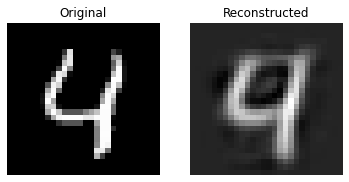

* Reconstructoed image produced by the convolutional autoencoder:

  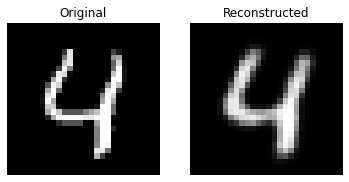

### Decoders Behavior on Noisy Encodings

We can also infer a great deal about the models if we look at the results of the additional test I performed - the behavior of the decoders around noise.

Let's start with the images the encoders produced when we fed random noise through them. Those images represent ***the deep nature of the latent encodings they learned to create and decipher***. The difference between them is actually dramatic. Beyond the difference in smoothness which we covered in the previous cell, there is a protrusive difference between the apparent patterns they produced.

It seems like the convolutional model uses its learned latent encodings to generate mainly solid twists of strong black-to-white edges, located evenly all across the "canvas". This makes sense as it uses deconvolutions - which are very local operations (especially in our case - in which we use tiny 4x4 kernels). So, the information it learned to embed in its latent encoding relate to what it knows should be in small patches across the training images - which are mainly black-to-white edges. Those are evenly distributed as it can't incorporate information about location when applying these local operations. It's fascinating to see the way the model learned to get around the problem it was fit to solve.

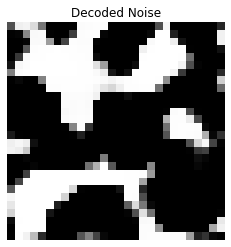

The FC connected layer learned to associate its 32-long latent encodings with completely different patterns - thin brushes of white, distributed around the middle of the image. The fact that the patterns emerge in the center makes sense due to the first key difference described above - the fact that the FC model can learn to associate the individual role of every neuron. It understands that pixels around the edges are almost always black (as the samples in MNIST are centered around their center-of-mass), and decides to discard the information they posses when "designing" its compressed encoding format. And as for the the thin brushes - this is the normal pattern of the pen in MNIST samples (though much less smoothed), and as the model is not restricted to look locally (in contrast to the convolutional one that mainly sees edges), it can associate its latent encoding directly with those patterns.

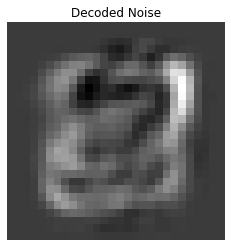

Finally - let's examine the behaviour of the decoders after adding noise to the encoding of a real image. There's not much to cover here, just a simple difference between the models. In the FC model, the decoded image did not change a great deal after imposing noise to the encoding of the real image. However, in the convolutional model some weird artifacts suddenly appeared. This follows from the unusual smoothness of the decoded images in the FC model which we covered in the previous cell in detail. The idea is that its manifestation in every step of the image formation (in every decoder layer) smooths out the resulting artifacts, preventing them from becoming meaningful later down the line.

* Image reconstructions after imposing noise on the encodings. On the top - the FC model's result; on the bottom - the convolutional model's result.

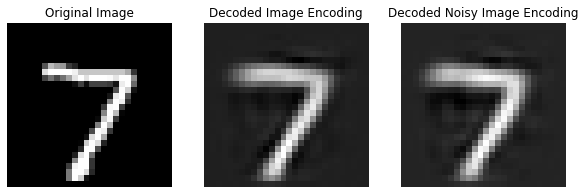

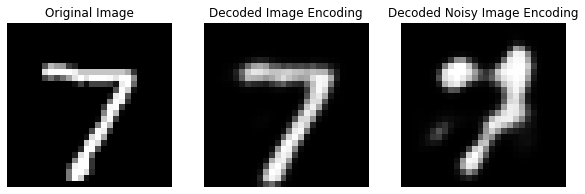



### Individual Encoder-Decoder Inversion Error

Last but not least, let's take a look the inversion loss of each individual encoder-decoder pair of layers in our models.

The results on the FC model:

```
Inversion loss between encoder-decoder pair 0 of FC InverserAutoencoder: 0.0197
Inversion loss between encoder-decoder pair 1 of FC InverserAutoencoder: 0.0006
Inversion loss between encoder-decoder pair 2 of FC InverserAutoencoder: 0.0002
Inversion loss between encoder-decoder pair 3 of FC InverserAutoencoder: 0.0001
Inversion loss between encoder-decoder pair 4 of FC InverserAutoencoder: 0.0001

The loss between the furthest pair of encoder-decoder layers in FC InverserAutoencoderis is 95.16% of the total test loss.
```

The results on the convolutional model:

```
Inversion loss between encoder-decoder pair 0 of Conv InverserAutoencoder: 0.0136
Inversion loss between encoder-decoder pair 1 of Conv InverserAutoencoder: 0.0012
Inversion loss between encoder-decoder pair 2 of Conv InverserAutoencoder: 0.0002
Inversion loss between encoder-decoder pair 3 of Conv InverserAutoencoder: 0.0001
Inversion loss between encoder-decoder pair 4 of Conv InverserAutoencoder: 0.0001

The loss between the furthest pair of encoder-decoder layers in Conv InverserAutoencoderis is 89.27% of the total test loss.
```

In both cases it appears that the further we go, the smaller the error is. And this makes sense: as the the pair of the encoder layer and the decoder layer is closer, the easier it is for the network to make their activations closer.

This, however, does not explain the dramatic drop in the error after the first pair - which makes the first error dominate the total loss (it is 95.16% of the total loss in the FC model, and 89.27% of the total loss in the convolutional model). This stems from the fact that the input to all encoder layers but the first one is actually another encoder layer's output - which allows the model to make them automatically closer to the corresponding learned decoder outputs. In contrast, the input to the first encoder layer is completely external - it is the image samples. Here the model really needs to work hard to get them right, it cannot "cheat" by engineering the input.

Finally - there is a relatively large margin between the part that the first pair's error has in the total loss in both models. In the FC model it's higher - 95.16%, while in the convolutional model it's lower - 89.27%. This follows from the fact that the FC model has (much) more learned parameters, so it can fit its encoder outputs better to be close to the corresponding decoder outputs. This makes the error they impose smaller, and the first pair's error part larger.

### GL ^_^